In [1]:
import kagglehub

# Download latest version
DATA_PATH = kagglehub.dataset_download("theseus200719/math-equations-dataset-aidav7-modified")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import cv2
import os
import ast
import numpy as np
from tqdm import tqdm
import json

In [3]:
# Подгоняем изображения под общий размер, сохраняя отношение сторон. Паддим справа.
def resize_and_pad(img, target_height=64, target_width=256):
    # Проверяем, что изображение загружено корректно
    if img is None:
        raise ValueError("Не удалось загрузить изображение")
    
    h, w = img.shape
    if h == 0 or w == 0:
        raise ValueError("Изображение имеет нулевые размеры")
    
    scale = target_height / h
    new_w = int(w * scale)

    if new_w > target_width:
        new_w = target_width

    resized = cv2.resize(img, (new_w, target_height))

    padded = np.zeros((target_height, target_width), dtype=np.float32)
    padded[:, :new_w] = resized

    return padded

In [4]:
# ===== Dataset =====
class FormulaDataset(Dataset):
    def __init__(self, path, vocab, transform=None):
        self.data = pd.read_csv(os.path.join(path, 'annotations.csv'))
        self.img_dir = os.path.join(path, 'images')
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # --- картинка ---
        img_path = os.path.join(self.img_dir, row['filenames'])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Проверяем, что изображение загружено
        if img is None:
            raise ValueError(f"Не удалось загрузить изображение: {img_path}")
        
        img = resize_and_pad(img)
        img = img / 255.0 # нормируем
        img = torch.tensor(img).unsqueeze(0).float()  # (1,H,W)

        # --- токены ---
        try:
            info = ast.literal_eval(row['image_data'])
            tokens = info['full_latex_chars']   # список строк-токенов
            token_ids = self.vocab.encode(tokens)
        except (ValueError, SyntaxError, KeyError) as e:
            raise ValueError(f"Ошибка при обработке токенов для строки {idx}: {e}")

        return img, torch.tensor(token_ids)


In [5]:
# ===== Vocabulary =====
class Vocab:
    def __init__(self, token_list):

        # спец символы
        self.pad = "<pad>"
        self.bos = "<bos>"
        self.eos = "<eos>"
        self.unk = "<unk>"

        self.tokens = [self.pad, self.bos, self.eos, self.unk] + sorted(token_list)
        self.stoi = {t: i for i, t in enumerate(self.tokens)}
        self.itos = {i: t for t, i in self.stoi.items()}

        self.length = len(self.tokens)  # ATTENTION!!!

    def __len__(self):
        return self.length

    def encode(self, token_seq):
        if not isinstance(token_seq, list):
            raise ValueError(f"Expected list of tokens, got {type(token_seq)}")
        
        if not all(isinstance(t, str) for t in token_seq):
            raise ValueError("All tokens must be strings")
        
        return [self.stoi[self.bos]] + \
               [self.stoi.get(t, self.stoi[self.unk]) for t in token_seq] + \
               [self.stoi[self.eos]]

    def decode(self, ids):
        # Декодируем и обрезаем по первому <eos>.
        eos_id = self.stoi[self.eos]
        pad_id = self.stoi[self.pad]
        bos_id = self.stoi[self.bos]

        toks = []
        for i in ids:
            if i == eos_id:
                break
            # Пропускаем pad и bos токены
            if i not in (pad_id, bos_id):
                toks.append(self.itos[i])

        return " ".join(toks)


In [ ]:
df = pd.read_csv(os.path.join(DATA_PATH, "annotations.csv"))

In [17]:
df[df['filenames'] == '001d21ff-cb96-4c6b-8ce1-3f5b9286ba80.jpg']

,filenames,latex,uuid,unicode_str,unicode_less_curlies,image_data,font
40503,001d21ff-cb96-4c6b-8ce1-3f5b9286ba80.jpg,\lim_{n\to2}\frac{n-5}{n+6},001d21ff-cb96-4c6b-8ce1-3f5b9286ba80,ƀ{nƄ2}ಭ{n-5}{n+6},ƀnƄ2ಭn-5n+6,"{'full_latex_chars': ['\\lim_', '{', 'n', '\\t...",Oct_252


In [13]:
# Ищем уникальные токены из всего списка токенов
df = pd.read_csv(os.path.join(DATA_PATH, "annotations.csv"))

all_token_lists = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    info = ast.literal_eval(row['image_data'])
    tokens = info['full_latex_chars']
    all_token_lists.append(tokens)

unique_tokens = set()
for seq in all_token_lists:
    unique_tokens.update(seq)

100%|██████████| 100000/100000 [01:24<00:00, 1178.71it/s]


In [14]:
with open("tokens.json", "w") as f:
    json.dump(list(unique_tokens), f)

In [6]:
with open("tokens.json", "r") as f:
    token_list = json.load(f)

vocab = Vocab(token_list)
print(vocab.tokens)

['<pad>', '<bos>', '<eos>', '<unk>', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '[', '\\cdot', '\\cos', '\\cot', '\\csc', '\\frac', '\\infty', '\\left(', '\\left|', '\\lim_', '\\ln', '\\log', '\\pi', '\\right)', '\\right|', '\\sec', '\\sin', '\\sqrt', '\\tan', '\\theta', '\\to', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'k', 'n', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}']


In [7]:
def collate_fn(batch):
    if not batch:
        raise ValueError("Пустой батч")
    
    imgs, seqs = zip(*batch)

    # картинки
    imgs = torch.stack(imgs, dim=0)

    # токены паддим до максимальной длины в батче
    if not seqs:
        raise ValueError("Нет последовательностей в батче")
    
    max_len = max(len(seq) for seq in seqs)
    if max_len == 0:
        raise ValueError("Все последовательности пустые")
    
    padded_seqs = torch.full((len(seqs), max_len), fill_value=vocab.stoi[vocab.pad], dtype=torch.long)

    for i, seq in enumerate(seqs):
        if len(seq) > 0:
            padded_seqs[i, :len(seq)] = seq

    return imgs, padded_seqs

In [8]:
# создаём датасет
dataset = FormulaDataset(DATA_PATH, vocab)

In [9]:

# Разделяем на train (80%), val (10%), test (10%)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, pin_memory=True, collate_fn=collate_fn)

In [ ]:
# --- CNN encoder ---
class CNNEncoder(nn.Module):
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, hidden_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_dim), nn.ReLU(),
        )

    def forward(self, x):
        feats = self.conv(x)  # [B,Hid,h,w]
        B, C, H, W = feats.shape
        # Преобразуем в последовательность: [B, H*W, C]
        feats = feats.permute(0, 2, 3, 1).reshape(B, H*W, C)
        return feats  # [B, seq_len, hidden_dim]


In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, num_layers=4, nhead=8, dropout=0.1, max_len=512):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, hidden_dim)
        self.pos_emb = nn.Embedding(max_len, hidden_dim)
        self.max_len = max_len

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        
        # Создаем маску один раз и кэшируем
        self.register_buffer('causal_mask', torch.triu(torch.ones(max_len, max_len), diagonal=1).bool())

    def forward(self, tgt, memory):
        B, T = tgt.shape
        tok_emb = self.token_emb(tgt)  # [B,T,H]
        pos = self.pos_emb(torch.arange(T, device=tgt.device))  # [T,H]
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        tgt_emb = tok_emb + pos

        # Используем маску
        tgt_mask = self.causal_mask[:T, :T]

        out = self.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask)  # [B,T,H]
        return self.fc_out(out)

In [ ]:
# Итоговая модель 
class FormulaRecognizer(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, max_len=512):
        super().__init__()
        self.encoder = CNNEncoder(hidden_dim)
        self.decoder = TransformerDecoder(vocab_size, hidden_dim, max_len=max_len)
        self.max_len = max_len
        self.vocab_size = vocab_size

    def forward(self, images, tokens):
        memory = self.encoder(images)  # [B,S,H]
        out = self.decoder(tokens[:, :-1], memory)  # предсказываем без последнего токена
        return out  # [B,T-1,V]

    def greedy_decode(self, image, vocab, device="cpu"):
        self.eval()
        with torch.no_grad():
            memory = self.encoder(image.unsqueeze(0).to(device))  # [1,S,H]

            # Используем правильные токены из словаря
            start_token = vocab.stoi[vocab.bos]
            end_token = vocab.stoi[vocab.eos]
            
            tokens = torch.tensor([[start_token]], device=device)
            for _ in range(self.max_len):
                out = self.decoder(tokens, memory)  # [1,T,V]
                next_token = out[:, -1, :].argmax(-1)  # [1]
                tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)
                if next_token.item() == end_token:
                    break

        return tokens.squeeze(0).tolist()

In [ ]:
def train_model(model, train_loader, val_loader, test_loader, tokenizer, epochs=5, device="cuda"):
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.stoi[tokenizer.pad])  # паддинг
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    model = model.to(device)

    for epoch in range(epochs):
        # ---------- TRAIN ----------
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for imgs, tokens in train_bar:
            imgs, tokens = imgs.to(device), tokens.to(device)

            optimizer.zero_grad()
            outputs = model(imgs, tokens[:, :-1])  # [B, T-1, vocab_size]

            # делаем срез по минимальной длине
            min_len = min(outputs.size(1), tokens[:, 1:].size(1))
            outputs = outputs[:, :min_len, :]
            targets = tokens[:, 1:1+min_len]

            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                targets.reshape(-1)
            )

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            
            preds = outputs.argmax(-1)  # [B, T]
            pad_id = tokenizer.stoi[tokenizer.pad]
            
            for i in range(preds.size(0)):
                pred_tokens = preds[i].cpu().tolist()
                true_tokens = tokens[i, 1:1+min_len].cpu().tolist()
                
                for j in range(min(len(pred_tokens), len(true_tokens))):
                    if true_tokens[j] != pad_id:
                        if pred_tokens[j] == true_tokens[j]:
                            train_correct += 1
                        train_total += 1
            
            train_bar.set_postfix(loss=loss.item(), acc=f"{train_correct/train_total:.3f}")

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = train_correct / train_total if train_total > 0 else 0

        # ---------- VALID ----------
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        examples = []
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for imgs, tokens in val_bar:
                imgs, tokens = imgs.to(device), tokens.to(device)
                outputs = model(imgs, tokens[:, :-1])

                min_len = min(outputs.size(1), tokens[:, 1:].size(1))
                outputs = outputs[:, :min_len, :]
                targets = tokens[:, 1:1+min_len]

                loss = criterion(
                    outputs.reshape(-1, outputs.size(-1)),
                    targets.reshape(-1)
                )
                val_loss += loss.item()

                # Подсчет accuracy для валидационной выборки (по токенам)
                preds = outputs.argmax(-1)  # [B, T]
                pad_id = tokenizer.stoi[tokenizer.pad]
                
                for i in range(preds.size(0)):
                    # Сравниваем токены по отдельности
                    pred_tokens = preds[i].cpu().tolist()
                    true_tokens = tokens[i, 1:1+min_len].cpu().tolist()
                    
                    # Считаем совпадения только для не-pad токенов
                    for j in range(min(len(pred_tokens), len(true_tokens))):
                        if true_tokens[j] != pad_id:  # Игнорируем pad токены в истинных значениях
                            if pred_tokens[j] == true_tokens[j]:
                                val_correct += 1
                            val_total += 1

                if len(examples) < 3:
                    pred_text = tokenizer.decode([t for t in preds[0].cpu().tolist() if t != pad_id])
                    true_text = tokenizer.decode([t for t in tokens[0, 1:1+min_len].cpu().tolist() if t != pad_id])
                    examples.append((pred_text, true_text))

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.3f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.3f}")
        for i, (pred, true) in enumerate(examples):
            print(f"  EX{i+1}: pred = {pred}")
            print(f"       true = {true}")

        torch.save(model.state_dict(), os.path.join("models",f"model_epoch{epoch+1}.pth"))
        print(f"Model saved: model_epoch{epoch+1}.pth")
    
    # Финальная оценка на тестовой выборке
    print("\n" + "="*50)
    print("ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
    print("="*50)
    
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    test_examples = []
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Тестирование")
        for imgs, tokens in test_bar:
            imgs, tokens = imgs.to(device), tokens.to(device)
            outputs = model(imgs, tokens[:, :-1])

            min_len = min(outputs.size(1), tokens[:, 1:].size(1))
            outputs = outputs[:, :min_len, :]
            targets = tokens[:, 1:1+min_len]

            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                targets.reshape(-1)
            )
            test_loss += loss.item()

            # Подсчет accuracy для тестовой выборки (по токенам)
            preds = outputs.argmax(-1)  # [B, T]
            pad_id = tokenizer.stoi[tokenizer.pad]
            
            for i in range(preds.size(0)):
                # Сравниваем токены по отдельности
                pred_tokens = preds[i].cpu().tolist()
                true_tokens = tokens[i, 1:1+min_len].cpu().tolist()
                
                # Считаем совпадения только для не-pad токенов
                for j in range(min(len(pred_tokens), len(true_tokens))):
                    if true_tokens[j] != pad_id:  # Игнорируем pad токены в истинных значениях
                        if pred_tokens[j] == true_tokens[j]:
                            test_correct += 1
                        test_total += 1

            if len(test_examples) < 5:  # Показываем больше примеров для теста
                pred_text = tokenizer.decode([t for t in preds[0].cpu().tolist() if t != pad_id])
                true_text = tokenizer.decode([t for t in tokens[0, 1:1+min_len].cpu().tolist() if t != pad_id])
                test_examples.append((pred_text, true_text))

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / test_total if test_total > 0 else 0
    print(f"\nФинальная оценка на тестовой выборке:")
    print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.3f}")
    print(f"Test Examples:")
    for i, (pred, true) in enumerate(test_examples):
        print(f"  TEST{i+1}: pred = {pred}")
        print(f"           true = {true}")
    
    return avg_test_loss, test_accuracy


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = FormulaRecognizer(vocab_size=len(vocab))

In [ ]:
test_loss, test_accuracy = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    tokenizer=vocab,
    epochs=15,
    device=device
)


Epoch 1/15 [Val]: 100%|██████████| 313/313 [01:40<00:00,  3.12it/s]



Epoch 1/15 | Train Loss: 0.9094 | Train Acc: 0.725 | Val Loss: 0.6104 | Val Acc: 0.797
  EX1: pred = \lim_ { y \to \infty \infty } { + } } \frac { h ^ 2 } { h h - 2 \right) \left( h + 2 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { w \to 2 } \frac \left( \left( \sin { \left( 2 b \right) } \frac { d } { d b } \sin { \left( 2 b \right) } + \sin { \left( 2 b \right) } \frac { d } { d b } \sin { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { h \to \infty } \frac { 2 t ^ { 2 } } - } ^ { 2 } } { t \left| ^ { 2 } +
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch1.pth

Epoch 2/15 [Val]: 100%|██████████| 313/313 [01:33<00:00,  3.33it/s]



Epoch 2/15 | Train Loss: 0.5487 | Train Acc: 0.818 | Val Loss: 0.4118 | Val Acc: 0.865
  EX1: pred = \lim_ { h \to 4 7 } { + } } \frac { h ^ 7 } { \left( h - 2 \right) \left( h + 2 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { w \to 1 } 2 2 \left( \sin { \left( b b \right) } \frac { d } { d b } \tan { \left( b b \right) } + \cos { \left( b b \right) } \frac { d } { d b } \sin { \left( 4 b \right) } \right) } { \lim_ { b \to 2 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { x \to \infty } \frac { 8 t ^ { 7 } + 0 t ^ { 7 } } { 8 t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch2.pth


Epoch 3/15 [Val]: 100%|██████████| 313/313 [01:33<00:00,  3.33it/s]



Epoch 3/15 | Train Loss: 0.3661 | Train Acc: 0.881 | Val Loss: 0.4389 | Val Acc: 0.868
  EX1: pred = \lim_ { h \to 4 4 } { + } } \frac { h ^ 7 } { \left( h - 2 \right) \left( h + 2 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { \theta \to 1 } 2 \left( \left( \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \tan { \left( 0 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } \right) } { \lim_ { b \to 1 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 7 } + { t t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch3.pth


Epoch 4/15 [Val]: 100%|██████████| 313/313 [01:35<00:00,  3.28it/s]



Epoch 4/15 | Train Loss: 0.2869 | Train Acc: 0.907 | Val Loss: 0.2421 | Val Acc: 0.920
  EX1: pred = \lim_ { h \to - 2 } { - } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { y \to 1 } 4 4 \left( \tan { \left( b b \right) } \frac { d } { d b } \tan { \left( b b \right) } + \tan { \left( b b \right) } \frac { d } { d b } \tan { \left( 0 b \right) } \right) } { \lim_ { b \to 1 } 1 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t } { 1 } } { t \left| ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch4.pth


Epoch 5/15 [Val]: 100%|██████████| 313/313 [01:35<00:00,  3.29it/s]



Epoch 5/15 | Train Loss: 0.2477 | Train Acc: 0.919 | Val Loss: 0.2194 | Val Acc: 0.928
  EX1: pred = \lim_ { h \to - 7 } { - } } \frac { 7 - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { w \to 1 } 2 2 \left( \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } \right) } { \lim_ { b \to 1 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t } { 1 } } { t t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch5.pth


Epoch 6/15 [Val]: 100%|██████████| 313/313 [01:40<00:00,  3.13it/s]



Epoch 6/15 | Train Loss: 0.2217 | Train Acc: 0.927 | Val Loss: 0.2098 | Val Acc: 0.931
  EX1: pred = \lim_ { h \to - 1 ^ { - } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { a \to 1 } 2 4 \left( \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t } { 7 } } { 3 t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch6.pth


Epoch 7/15 [Val]: 100%|██████████| 313/313 [01:40<00:00,  3.11it/s]



Epoch 7/15 | Train Loss: 0.2019 | Train Acc: 0.934 | Val Loss: 0.1896 | Val Acc: 0.938
  EX1: pred = \lim_ { h \to - 2 ^ { - } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 7 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { t \to 1 } 2 1 \left( \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } \right) } { \lim_ { b \to 1 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t } { 1 } } { t t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch7.pth


Epoch 8/15 [Val]: 100%|██████████| 313/313 [01:39<00:00,  3.14it/s]



Epoch 8/15 | Train Loss: 0.1863 | Train Acc: 0.939 | Val Loss: 0.1812 | Val Acc: 0.941
  EX1: pred = \lim_ { h \to - 4 ^ { - } } \frac { h - 7 } { \left( h - 7 \right) \left( h + 2 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { h \to 1 } 1 1 \left( \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \cos { \left( b b \right) } \frac { d } { d b } \tan { \left( b b \right) } \right) } { \lim_ { b \to 1 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch8.pth


Epoch 9/15 [Val]: 100%|██████████| 313/313 [01:39<00:00,  3.14it/s]



Epoch 9/15 | Train Loss: 0.1745 | Train Acc: 0.943 | Val Loss: 0.1782 | Val Acc: 0.943
  EX1: pred = \lim_ { h \to - 9 ^ { - } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { h \to 1 } 1 9 \left( \tan { \left( 9 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t } { 1 } } { 3 t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch9.pth


Epoch 10/15 [Val]: 100%|██████████| 313/313 [01:39<00:00,  3.14it/s]



Epoch 10/15 | Train Loss: 0.1641 | Train Acc: 0.946 | Val Loss: 0.1649 | Val Acc: 0.946
  EX1: pred = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { h \to 1 } 9 1 \left( \tan { \left( 9 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 1 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 1 } + 4 t ^ { 1 } - { 3 t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch10.pth


Epoch 11/15 [Val]: 100%|██████████| 313/313 [01:39<00:00,  3.14it/s]



Epoch 11/15 | Train Loss: 0.1551 | Train Acc: 0.949 | Val Loss: 0.1584 | Val Acc: 0.949
  EX1: pred = \lim_ { h \to - 2 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { h \to 1 } 2 0 \left( \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 1 } 4 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch11.pth


Epoch 12/15 [Val]: 100%|██████████| 313/313 [01:39<00:00,  3.15it/s]



Epoch 12/15 | Train Loss: 0.1486 | Train Acc: 0.951 | Val Loss: 0.1565 | Val Acc: 0.950
  EX1: pred = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 7 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { a \to 1 } 2 0 \left( \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 7 } - { 3 t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch12.pth


Epoch 13/15 [Val]: 100%|██████████| 313/313 [01:40<00:00,  3.12it/s]



Epoch 13/15 | Train Loss: 0.1428 | Train Acc: 0.953 | Val Loss: 0.1498 | Val Acc: 0.951
  EX1: pred = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 7 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { w \to 1 } 2 0 \left( \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 1 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 0 ^ { 7 } + 4 } + { 1 } } { 3 t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch13.pth


Epoch 14/15 [Val]: 100%|██████████| 313/313 [01:39<00:00,  3.13it/s]



Epoch 14/15 | Train Loss: 0.1358 | Train Acc: 0.955 | Val Loss: 0.1545 | Val Acc: 0.951
  EX1: pred = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 3 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { w \to 1 } 1 0 \left( \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } \right) } { \lim_ { b \to 5 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch14.pth


Epoch 15/15 [Val]: 100%|██████████| 313/313 [01:39<00:00,  3.14it/s]



Epoch 15/15 | Train Loss: 0.1308 | Train Acc: 0.957 | Val Loss: 0.1535 | Val Acc: 0.951
  EX1: pred = \lim_ { h \to - 9 ^ { - } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
       true = \lim_ { h \to - 9 ^ { + } } \frac { h - 7 } { \left( h - 2 \right) \left( h + 2 \right) }
  EX2: pred = \frac { \lim_ { n \to 9 } 2 0 \left( \tan { \left( 2 b \right) } \frac { d } { d b } \tan { \left( 2 b \right) } + \cos { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
       true = \frac { \lim_ { b \to 7 } 2 0 \left( \tan { \left( 4 b \right) } \frac { d } { d b } \tan { \left( 3 b \right) } + \tan { \left( 2 b \right) } \frac { d } { d b } \cos { \left( 2 b \right) } \right) } { \lim_ { b \to 2 } 2 }
  EX3: pred = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
       true = \lim_ { t \to \infty } \frac { 8 t ^ { 7 } + 4 t ^ { 1 } } { 3 t ^ { 9 } }
Model saved: model_epoch15.pth

ФИНАЛЬНАЯ ОЦЕНК

Тестирование: 100%|██████████| 157/157 [00:48<00:00,  3.24it/s]


Финальная оценка на тестовой выборке:
Test Loss: 0.1555 | Test Accuracy: 0.950
Test Examples:
  TEST1: pred = \lim_ { x \to - \infty } \frac { 9 8 x ^ { 6 } } 7 } { 1 x ^ { 2 } + - 5 x ^ { 0 } }
           true = \lim_ { x \to - \infty } \frac { 9 8 x ^ { 6 } - 7 } { 1 x ^ { 2 } + - 5 x ^ { 6 } }
  TEST2: pred = \lim_ { r \to 2 ^ { + } } \frac { \frac { d } { d t } \left( 6 + - 6 \sin ^ { 0 } { t } \right) } { \frac { d } { d t } \left( \tan { t } + t \tan ^ { 3 } { t } \right) }
           true = \lim_ { t \to 2 ^ { + } } \frac { \frac { d } { d t } \left( 6 + - 6 \sin ^ { 0 } { t } \right) } { \frac { d } { d t } \left( \tan { t } + t \tan ^ { 3 } { t } \right) }
  TEST3: pred = = \lim_ { p \to \infty } \frac { 3 p ^ { 2 } } { 4 p ^ { 3 } + 6 \left| p ^ { 1 } \right| }
           true = = \lim_ { p \to \infty } \frac { 3 p ^ { 1 } } { 4 p ^ { 3 } + 6 \left| p ^ { 1 } \right| }
  TEST4: pred = \lim_ { u \to \pi { \pi } { 3 } ^ { - } } \frac { \sin ^ { 5 } { u } } { 4 \frac { 3 } { 3 

In [15]:
import matplotlib.pyplot as plt
import os
import torch
import cv2

def test_inference(model, vocab, device="cuda", model_path=None, test_image_path=None):
    if model_path and os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
    
    model = model.to(device)
    model.eval()
    
    if test_image_path is None:
        val_dataset = val_loader.dataset
        random_idx = torch.randint(0, len(val_dataset), (1,)).item()
        img, true_tokens = val_dataset[random_idx]
        
        pad_id = vocab.stoi[vocab.pad]
        true_text = vocab.decode([t for t in true_tokens.tolist() if t != pad_id])
        img_np = img.squeeze(0).numpy()  # [H,W]
    else:
        if not os.path.exists(test_image_path):
            print(f"Файл {test_image_path} не найден")
            return
        
        img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Не удалось загрузить изображение {test_image_path}")
            return
        
        img = resize_and_pad(img)
        img_np = img.copy()  # сохраним для отображения
        img = img / 255.0
        img = torch.tensor(img).unsqueeze(0).float()
        true_text = None
    
    result_tokens = model.greedy_decode(img, vocab, device)
    result_text = vocab.decode([t for t in result_tokens if t != vocab.stoi[vocab.pad]])
    
    print(f"Результат: {result_text}")
    if true_text is not None:
        print(f"Истинная:  {true_text}")
    
    # --- вывод изображения ---
    plt.imshow(img_np, cmap="gray")
    plt.axis("off")
    plt.title("Test Image")
    plt.show()
    
    return result_text


====== ТЕСТИРОВАНИЕ ИНФЕРЕНСА ======

Тест на случайном изображении:
Результат: \lim_ { x \to \pi / 5 } \cos ^ { 7 } { x } + \sec ^ { 2 } { x }
Истинная:  \lim_ { x \to \pi / 5 } \cos ^ { 7 } { x } + \sec ^ { 2 } { x }


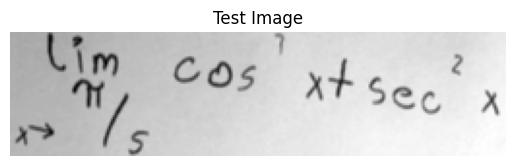



Тест на собственном изображении:
Результат: \lim_ { x \to \infty } \frac { x ^ { 2 } } { x ^ { 3 } }


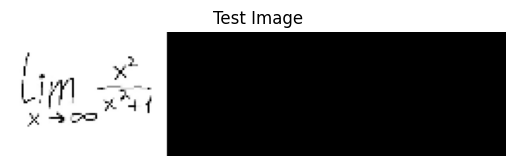

In [28]:
print("====== ТЕСТИРОВАНИЕ ИНФЕРЕНСА ======")


print("\nТест на случайном изображении:")
result = test_inference(
    model=model,
    vocab=vocab,
    device=device,
    model_path="models/model_epoch13.pth"
)


print("\n" + "="*50)

print("\nТест на собственном изображении:")

result = test_inference(
     model=model,
     vocab=vocab,
     device=device,
     model_path="models/model_epoch13.pth",
     test_image_path="test_images/limit_image.jpg"
 )
